# Proyecto Final 
## Alejandro Hernández Rodríguez
## Aprendizaje profundo 

## Análisis de profundidad y ancho de una red neuronal completamente conectada.

In [436]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
from itertools import islice as take
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import tqdm

### Objetivo

Supongase un problema de clasificación binaria, el objetivo es observar cómo en un una red neuronal fully connected, el ancho de cada capa oculta y el número de capas ocultas modifica el desempeño del modelo.

Para poder realizar este análisis utilice el conjunto de datos Breast Cancer Wisconsin, https://www.kaggle.com/uciml/breast-cancer-wisconsin-data. 

Es un conjunto de datos que contiene distintas carácterísticas sobre tumores en los pechos. Cada tumor tiene una etiqueta sobre si es maligno o benigno.

In [400]:
data = pd.read_csv('/content/data.csv')

In [401]:
del data['Unnamed: 32']
del data['id']


In [486]:
data.corr()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Intente realizar una selección de variables que presentaban multicolinealidad en los datos. Pero al hacerlo el desempeño de casi todos los clasificadores no era muy bueno.

In [473]:
#features = ['radius_mean', 'texture_mean', 'smoothness_mean','symmetry_mean','fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','symmetry_worst']
#X = data.loc[:, features].values

X = data.loc[:, data.columns != 'diagnosis'].values
n = Normalizer()

X = n.fit_transform(X)
y = np.array([1.0 if record == 'M' else 0.0 for record in data.loc[:, 'diagnosis']])

In [474]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [475]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

In [476]:
# tamaño del lote
batch_size = 128

# creamos un DataLoader
batched_train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
batched_test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

train_dl = DataLoader(train_ds, shuffle=True)
test_dl = DataLoader(test_ds, shuffle=True)

In [ ]:
class dynamicMLP(nn.Module):
    def __init__(self, neurons_per_layer):
        super(dynamicMLP,self).__init__()
        self.hidden_layers = nn.ModuleList()

        for i in range(1,len(neurons_per_layer)):
            self.hidden_layers.append(
                nn.Sequential(
                    nn.Linear(neurons_per_layer[i-1],neurons_per_layer[i]),
                    nn.ReLU()
                )
            )
        
        self.final_layer = nn.Linear(neurons_per_layer[-1], 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        hidden_outputs = []
        out = self.hidden_layers[0](x)
        hidden_outputs.append(out)
        out = self.dropout(out)
        for i in range(1,len(self.hidden_layers)):
            out = self.hidden_layers[i](out)
            hidden_outputs.append(out)
            out = self.dropout(out)

        out = self.final_layer(out)
        hidden_outputs.append(out)
        return out,hidden_outputs


La arquitectura de la red es una red neuronal completamente conectada, con máximo 2 capas y variando el número de neruonas en cada capa.

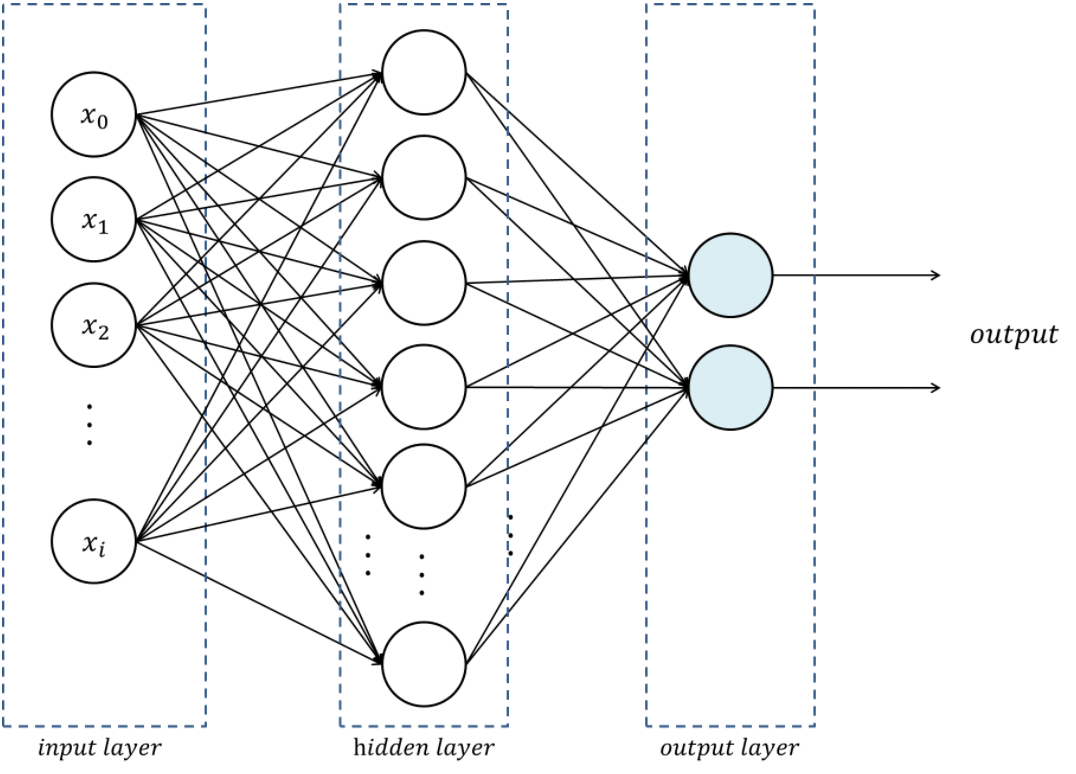

In [477]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        y_true = y_true.unsqueeze(1)


        # computamos logits
        y_lgts,ho = model(x.float())
        
        y_prob = torch.sigmoid(y_lgts)
        # computamos la pérdida
        loss = F.binary_cross_entropy(y_prob, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts,ho = model(x)
            y_true = y_true.unsqueeze(1)

            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            # computamos la clases
            y_pred = torch.tensor(np.array([1 if e[0] >= 0.5 else 0 for e in y_prob]))

            # computamos la pérdida
            loss = F.binary_cross_entropy(y_prob, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None, print_training = True):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        if print_training:                        
            print(f'E{epoch:02} '
                f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
                f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [ ]:
final_losses = []
final_accuracies = []
layer_pca_sg = []
layer_pca_components = []
layer_pca_variance_explained = []

m = 100
for i in range(1,m):
    
    model = dynamicMLP([30,i])
    loss_hist, acc_hist = train(model, train_dl, test_dl, epochs=20)
    
    final_losses.append(loss_hist[-1])
    final_accuracies.append(acc_hist[-1])

    w = model.hidden_layers[0][0].weight.detach().numpy()
    pca = PCA(n_components=min(w.shape))
    principalComponents = pca.fit(w)
    layer_pca_sg.append(principalComponents.singular_values_)
    layer_pca_components.append(principalComponents.components_)
    layer_pca_variance_explained.append(principalComponents.explained_variance_ratio_)

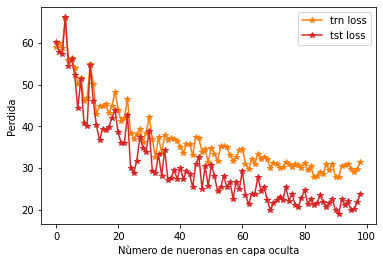

In [487]:
trn_loss, tst_loss = zip(*final_losses)
plt.plot(trn_loss, 'tab:orange', label='trn loss', marker='*')
plt.plot(tst_loss, 'tab:red', label='tst loss', marker='*')
plt.legend(loc='upper right')
plt.xlabel('Nùmero de nueronas en capa oculta')
plt.ylabel('Perdida')
plt.show()

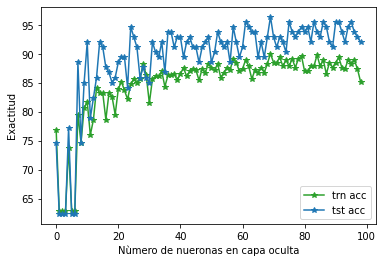

In [488]:
trn_acc, tst_acc = zip(*final_accuracies)
plt.plot(trn_acc, 'tab:green', label='trn acc', marker='*')
plt.plot(tst_acc, 'tab:blue', label='tst acc', marker='*')
plt.legend(loc='lower right')
plt.xlabel('Nùmero de nueronas en capa oculta')
plt.ylabel('Exactitud')
plt.show()

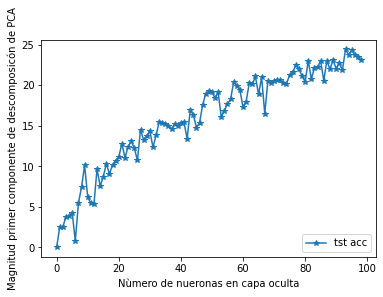

In [491]:
first_component_first_layer = [sing_values[0] for sing_values in first_layer_pca]
plt.plot(first_component_first_layer, 'tab:blue', label='tst acc',marker='*')
plt.legend(loc='lower right')
plt.xlabel('Nùmero de nueronas en capa oculta')
plt.ylabel('Magnitud primer componente de descomposicón de PCA')
plt.show()

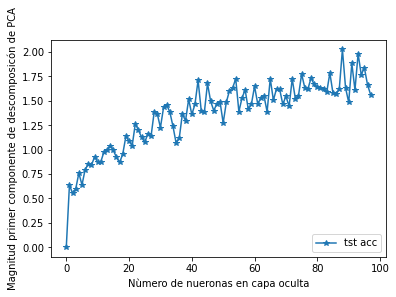

In [492]:
first_component_first_layer = [first_layer_pca[i][1] for i in range(1,len(first_layer_pca))]
plt.plot(first_component_first_layer, 'tab:blue', label='tst acc',marker='*')
plt.legend(loc='lower right')
plt.xlabel('Nùmero de nueronas en capa oculta')
plt.ylabel('Magnitud primer componente de descomposicón de PCA')
plt.show()

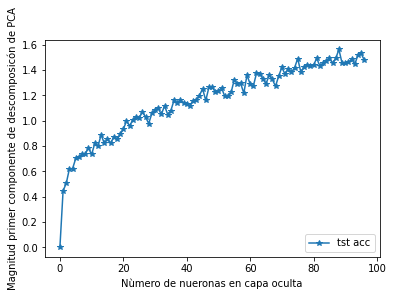

In [493]:
first_component_first_layer = [first_layer_pca[i][2] for i in range(2,len(first_layer_pca))]
plt.plot(first_component_first_layer, 'tab:blue', label='tst acc',marker='*')
plt.legend(loc='lower right')
plt.xlabel('Nùmero de nueronas en capa oculta')
plt.ylabel('Magnitud primer componente de descomposicón de PCA')
plt.show()

In [506]:
first_three = []

for i in range(2,len(layer_pca_variance_explained)):
    first_three.append(layer_pca_variance_explained[i][:3].tolist())
#plt.plot()    


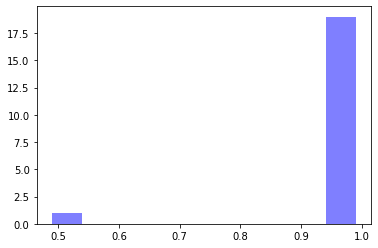

In [531]:
first_three = np.array(first_three)
n, bins, patches = plt.hist(first_three[:20,0], facecolor='blue', alpha=0.5)
plt.show()

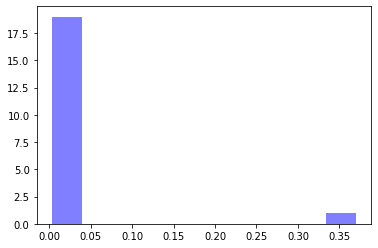

In [532]:
first_three = np.array(first_three)
n, bins, patches = plt.hist(first_three[:20,1], facecolor='blue', alpha=0.5)
plt.show()

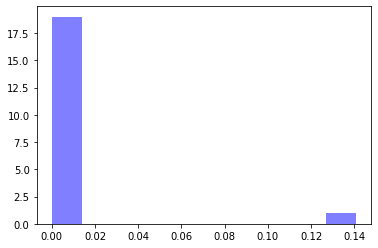

In [533]:
first_three = np.array(first_three)
n, bins, patches = plt.hist(first_three[:20,2], facecolor='blue', alpha=0.5)
plt.show()

In [427]:
def unbiased_HSIC(K, L):
    '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

    #create the unit **vector** filled with ones
    n = K.shape[0]
    ones = np.ones(shape=(n))

    #fill the diagonal entries with zeros 
    np.fill_diagonal(K, val=0) #this is now K_tilde 
    np.fill_diagonal(L, val=0) #this is now L_tilde

    #first part in the square brackets
    trace = np.trace(np.dot(K, L))

    #middle part in the square brackets
    nominator1 = np.dot(np.dot(ones.T, K), ones)
    nominator2 = np.dot(np.dot(ones.T, L), ones)
    denominator = (n-1)*(n-2)
    middle = np.dot(nominator1, nominator2) / denominator


    #third part in the square brackets
    multiplier1 = 2/(n-2)
    multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
    last = multiplier1 * multiplier2

    #complete equation
    unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

    return unbiased_hsic

def CKA(X, Y):
    '''Computes the CKA of two matrices. This is equation (1) from the paper'''

    nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
    denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
    denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

    cka = nominator/np.sqrt(denominator1*denominator2)

    return cka

In [440]:
def calculate_CKA_for_two_matrices(activationA, activationB):
    '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

    #unfold the activations, that is make a (n, h*w*c) representation
    shape = activationA.shape
    activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

    shape = activationB.shape
    activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

    #calculate the CKA score
    cka_score = CKA(activationA, activationB)

    del activationA
    del activationB

    return cka_score

def compare_activations(modelA, modelB, data_batch):
    '''
    Calculate a pairwise comparison of hidden representations and return a matrix
    '''

    #get function to get the output of every intermediate layer, for modelA and modelB
    out,intermediate_outputs_A = modelA(data_batch)
    out,intermediate_outputs_B = modelB(data_batch)

    #create a placeholder array
    result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))


    i = 0
    for outputA in intermediate_outputs_A:
        j = 0
        outputA = outputA.detach().numpy()
        for outputB in intermediate_outputs_B:
            outputB = outputB.detach().numpy()
            cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
            result_array[i, j] = cka_score
            j+=1
        i+= 1

    return result_array

# Comparativa con dos capas

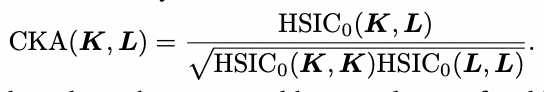

" Let $X \in R^
m\times p_1$ and $Y \in R
^m\times p_2$ contain representations of two layers, one with $p_1$ neurons and
another $p_2$ neurons, to the same set of $m$ examples. Each element of the $m \times m$ Gram matrices
$K = XX^T$ and $L = YY^T$  reflects the similarities between a pair of examples according to
the representations contained in $X$ or $Y$ . Let $H = I_n − \frac{1}{n}11^T$ be the centering matrix. Then
$K_0 = HKH$ and $L_0 = HLH$ reflect the similarity matrices with their column and row means
subtracted. "

$HSIC_0(K, L) = vec(K_0
)·vec(L_0
)/(m−
1)2$

In [412]:
data_sample = next(iter(batched_test_dl))


In [ ]:
m = [50,60]
n = [1,5,10,20]

models = {}
final_losses = {}
final_accuracies = {}

for i in m:
    for j in n:
        model = dynamicMLP([30,i,j])
        loss_hist, acc_hist = train(model, train_dl, test_dl, epochs=60)
        
        final_losses[(i,j)] = loss_hist[-1]
        final_accuracies[(i,j)] = acc_hist[-1]
        models[(i,j)] = model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


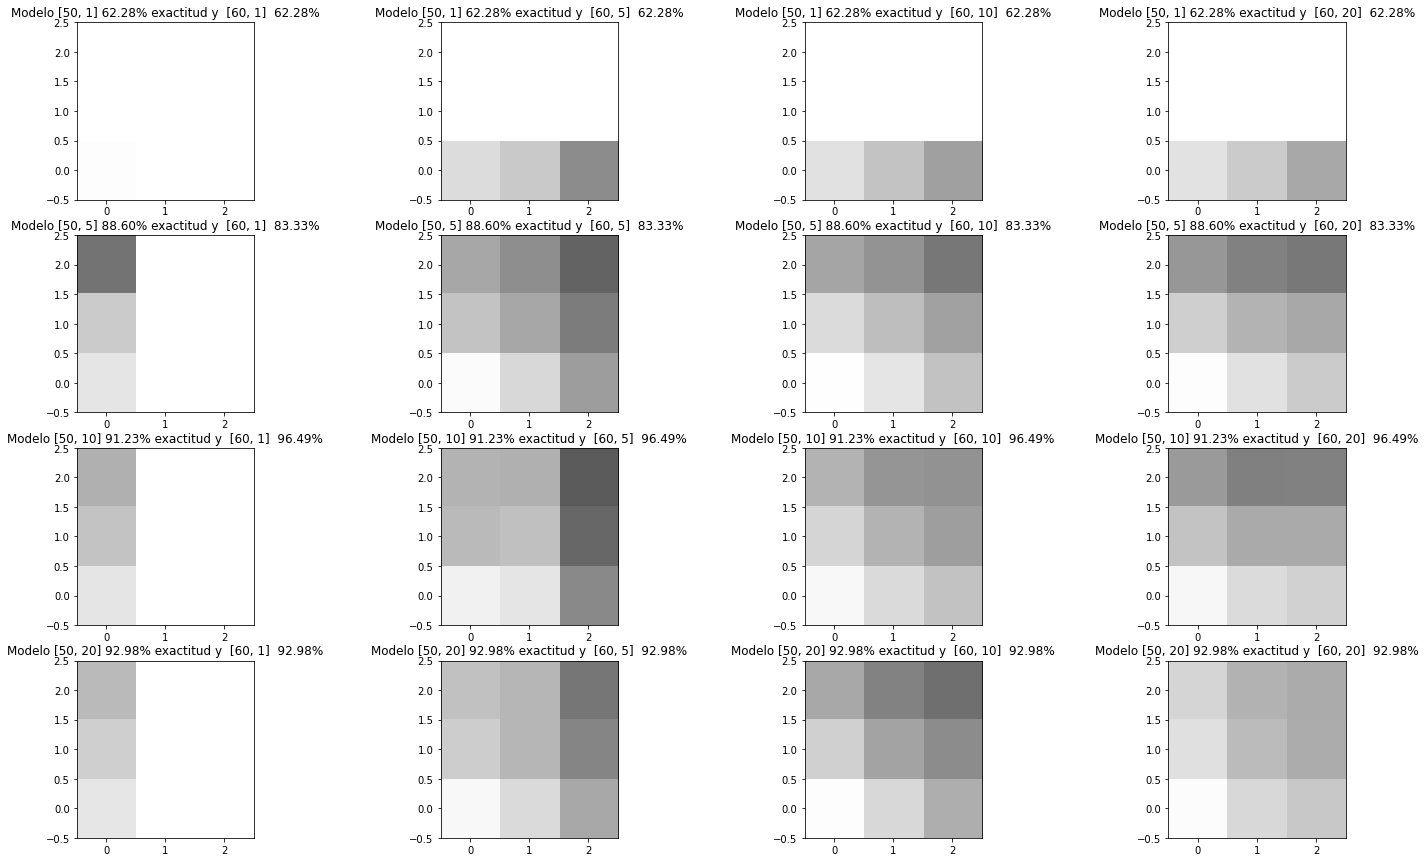

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [503]:
fig, axs = plt.subplots(4, 4,figsize=(25,15))

for p,i in enumerate(n):
    for k,j in enumerate(n):
        sim = compare_activations(models[50,i], models[60,j], data_sample[0])
        plt.figure(figsize=(6, 3), dpi=200)
        axs[p,k].imshow(sim, cmap='gray', vmin=0.0,vmax=1.0)
        axs[p,k].axes.invert_yaxis()
        axs[p,k].set_title(f'Modelo [50, {i}] {final_accuracies[50,i][1]:.2f}% exactitud y  [60, {j}]  {final_accuracies[60,i][1]:.2f}%')


## Referencias

https://arxiv.org/pdf/2010.15327.pdf